In [9]:
"""
Assignment 07, Problem 01

Ankit Agrawal (2581532)
Akshay Joshi (2581346)

Used boiler plate code provided by the tutor, added method to prune, find no. of parameters and, 
a loop to check and report perplexity for each value of epsilon while pruning

To run the code, upload English_train.txt and English_test.txt.

"""

from nltk.tokenize import word_tokenize
import string
from collections import defaultdict
from matplotlib import pyplot as plt
from collections import Counter
from math import log

def count_ngrams_hierarchical(text, n):
    counts={}
    for j in range(n):
        counts[j+1]=Counter(zip(*[text[i:] for i in range(j+1)]))
    return counts 

def compute_perplexity(jointProbabilityTest,distributionModel):
    sumlog = 0
    for testNgram,testNgramCount in jointProbabilityTest.items():
      sumlog += testNgramCount*log(distributionModel[testNgram],2)
    perplexity = pow(2, (-1) * sumlog) 
    return perplexity  


class discounting_model:
    def __init__(self, d, unigramCounts, bigramCounts):
        self._bigramCounts = bigramCounts
        self._unigramCounts = unigramCounts
        self._d = d
        trainTokens = set(bigram[-1] for bigram in bigramCounts.keys())
        self._V = len( unigramCounts)
        self._R = ()
        self.R = Counter(bigram[0:-1] for bigram,count in bigramCounts.items() if count > 0)    # solution
 
    #Fujnction to prune:
    def prune(self, epsilon):
        unigrams= self._unigramCounts
        bigrams = self._bigramCounts
        N = sum(self._unigramCounts.values())

        pruned_unigrams = dict((k, v) for k, v in unigrams.items() if self.__unigram__(k) > epsilon)
        pruned_bigrams = dict((k, v) for k, v in bigrams.items() if self[k] > epsilon)

        new_model = discounting_model(self._d, pruned_unigrams, pruned_bigrams)
        return new_model
    
    # Function to find parameters:
    def parameters(self):
        return len(self._unigramCounts), len(self._bigramCounts)

    def __unigram__(self, unigram):
        unigramCount=self._unigramCounts.get(unigram, 0)
        V, d = self._V, self._d
        zeroGramProb=1/V

        N = sum(self._unigramCounts.values())
        return max(unigramCount-d,0) / N + d*V / N * zeroGramProb


    def __getitem__(self, bigram):
        bigramCount = self._bigramCounts.get(bigram, 0)
        history = bigram[0:1]
        historyCount = self._unigramCounts.get(history, 0)
        unigram = bigram[1:]
        
        V, d = self._V, self._d
        N = sum(self._unigramCounts.values())
        nPlus = self.R[history]

        
        uniGramProb = self.__unigram__(unigram)

        if historyCount>0:
            prob = max(bigramCount - d,0)/ historyCount + d*nPlus/historyCount * uniGramProb

        else:
            prob = uniGramProb

        return prob


if __name__ == "__main__":
    tokens = open('English_train.txt', 'r', encoding='utf8').read().split()
    ngramCounts = count_ngrams_hierarchical(tokens, 2)

    tokens2 = open('English_test.txt', 'r', encoding='utf8').read().split() #tokenize('twain/pg3176.txt')
    ngramCountsTest = count_ngrams_hierarchical(tokens2, 2)
    N = sum(ngramCountsTest[1].values())-1

    jointDistribution= {bigram : bigramCount/N for bigram,bigramCount in ngramCountsTest[2].items()}
    mdl = discounting_model(0.9, ngramCounts[1], ngramCounts[2])
    
    ppl = compute_perplexity(jointDistribution, mdl)
    print("Absolute discounting:", ppl, mdl.parameters())

    for i in range(3, 7):
        pruned_model = mdl.prune(10**(-i))
        ppl2 = compute_perplexity(jointDistribution, pruned_model)
        len_uni, len_bi = pruned_model.parameters()
        print("PPL for 10^-", i, "is", ppl2, "with parameters, Unigram: ", len_uni, "and bigram: ", len_bi)

Absolute discounting: 466.3310949360129 (11469, 54359)
PPL for 10^- 3 is 1262.365194666873 with parameters, Unigram:  119 and bigram:  39524
PPL for 10^- 4 is 545.2145657998658 with parameters, Unigram:  1045 and bigram:  50270
PPL for 10^- 5 is 466.3310949360129 with parameters, Unigram:  11469 and bigram:  54359
PPL for 10^- 6 is 466.3310949360129 with parameters, Unigram:  11469 and bigram:  54359


**Output:**
Absolute discounting: 466.3310949360129 (11469, 54359)

PPL for 10^- 3 is 1262.365194666873 with parameters, Unigram:  119 and bigram:  39524

PPL for 10^- 4 is 545.2145657998658 with parameters, Unigram:  1045 and bigram:  50270

PPL for 10^- 5 is 466.3310949360129 with parameters, Unigram:  11469 and bigram:  54359

PPL for 10^- 6 is 466.3310949360129 with parameters, Unigram:  11469 and bigram:  54359

As we see, the perplexity decreases with the increase in value of n. 

Also, we can see that perplexity is same for epsilon where n=5 and n=6, as nothing gets pruned beyond a certain value of n because no probability is less than that value. So we retain all the ngrams and we don't need to back off to the lower order probability for them.

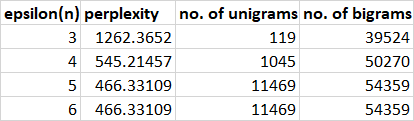
